# Assignment 3: Shengdi Lin

### 3 Practical Applications of GANs
1. Image Generation: GANs have been extensively used to generate realistic images, including faces, artwork, landscapes, and even objects. By training a GAN on a dataset of images, it learns to generate new images that are similar to the training data. This has applications in art, graphic design, and entertainment industries.
2. Data Augmentation: GANs can be used to augment training data for machine learning models. By generating synthetic data that closely resembles real data, GANs can help improve the performance and robustness of models trained on limited datasets. This is particularly useful in domains such as healthcare, where obtaining labeled data can be challenging due to privacy concerns.
3. Style Transfer: GANs can be utilized for artistic style transfer, where the style of one image or artwork is transferred to another image while preserving its content. By training a GAN on pairs of images, one representing content and the other representing style, the network learns to disentangle content and style representations. This allows users to apply the style of famous artworks or photographs to their own images, creating visually appealing and artistic compositions. Style transfer has applications in photography, graphic design, and the creation of visual effects in film and video production. Additionally, it can be used for enhancing and stylizing images for social media, advertising, and branding purposes.

### 3 Challenges for GANs
1. Mode Collapse: GANs sometimes exhibit "mode collapse," where the generator fails to capture the full range of diversity within the training data, resulting in generated samples lacking variety and quality. This challenge necessitates techniques like architectural adjustments, regularization methods, and alternative training strategies to overcome.
2. Training Instability: GAN training is marked by instability, manifested through fluctuations in loss functions and struggles to establish equilibrium between the generator and discriminator networks. Issues like vanishing or exploding gradients and mode dropping often arise, prompting the exploration of stabilization methods such as feature matching and gradient penalty.
3. Evaluation and Validation: Unlike discriminative models, which can be assessed using objective metrics like accuracy, evaluating GANs' performance is subjective and complex. Common metrics like Inception Score (IS) may not consistently align with what we wanted from the network, necessitating the development of more reliable evaluation metrics that better reflect the goal.

### Diagram

![alt text](diagram.png "Title")

For this GAN, our generic structure will similar to the above image. First, we create our generator and discriminator networks. Second, we find an appropriate dataset for what we are attempting to create (in this case, faces). Then, we start training the generator model by first giving it random input. This input will lead to a result that should be far from what our objective is. We compare this result using the discriminator network against the real faces. We repeat this cycle between the generator and discriminator networks to tune the weights. The weights are tuned using loss functions defined by the user. Importantly, we are tuning the weights to create new vectors in the generator network to create realistic faces. We will explore this vector processing in a later section. 

### Setup

First, let us ensure we have tensorflow set up correctly. We import in the tensorflow and tensorflow_hub packages. I am currently running tensorflow version 2.13.1 on this machine. 

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
tf.__version__

'2.13.1'

We ensure that we have imageio created to create gifs for us to visualize the learning process as well as the github tensorflow docs. 

In [14]:
# # Install imageio for creating animations. (uncomment if not installed already)
# !pip -q install imageio
# !pip -q install scikit-image
# !pip install git+https://github.com/tensorflow/docs

We will be using documentation from the progan-128 package, which is imported in the below code block. The model is trained on CelebA images, organized in a 128x128 format. The source can be found here: https://www.kaggle.com/models/google/progan-128/tensorFlow1/progan-128/1?tfhub-redirect=true


In [15]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

Here, we create supporting documentation that ensures image transformation using vector normalization is set up. It takes separate vectors from plausible images and creates a relationship between these. 

In [16]:
## IMPORT IN THE NECESSARY PACKAGES
from absl import logging
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_docs.vis import embed
import time
try:
  from google.colab import files
except ImportError:
  pass
from IPython import display
from skimage import transform
tf.random.set_seed(0)


# This defines the dimensions in the image
latent_dim = 512

## CREATE INTERPOLATION VECTOR FUNCTION TO WORK BOTH VECTORS
# Interpolates between two vectors that are non-zero and normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors to generate a coherent result from the two
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# displays image
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# show animation over a set of images
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

Here, we demonstrate the interpolation of vectors between two images through 25 total steps to generate realistic faces. 


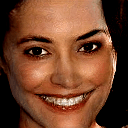

In [17]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])

  # Creates a tensor with 50 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

In the below code block, we ensure that we can draw data from the CelebA dataset as well as display it properly. 

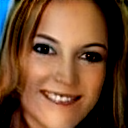

In [18]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }
tf.random.set_seed(69)

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

Autoencoders, such as the one we used in our weekly codesamples, is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit like our weekly exapmles, the autoencoder sets the image into a lower dimensional latent representation then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

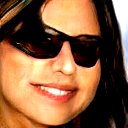

In [73]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In the below code, we optimize the latent vectors to ensure that the image actually follows its path towards its target. When generating these vectors, it is important to consider that faces have a specific mapping and hence our model should not stray too far form this path. This acts as our discriminator component by ensuring and categorizing which vector changes actually result in realistic looking faces for our generator model.

In [20]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

We plot the loss function below to see how our generator network performs against the discriminator with each epoch. After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values and vectors that minimize the loss appropriately. 

(0.0, 4115.716177368164)

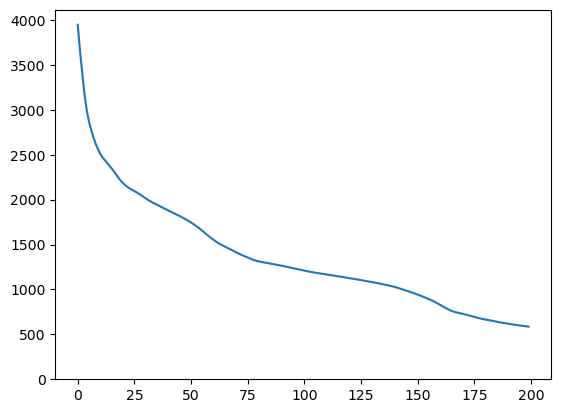

In [21]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])

Let us visualize this realistic face generation process:


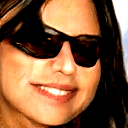

In [22]:
animate(np.stack(images))

### Analysis

Here, we can see that GAN has created a realistic face from a target image as well as from another image template. For our results, we can see that the image generated is quite realistic to our eyes. Furthermore, 

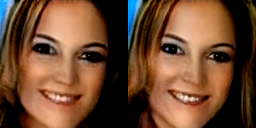

In [23]:
display_image(np.concatenate([images[-1], target_image], axis=1))

### Generate more random faces

In [74]:
tf.random.set_seed(36)
images = progan(tf.random.normal([20, 512]))
imgs = images['default']
print(imgs.shape)

(20, 128, 128, 3)


Display the generated images 

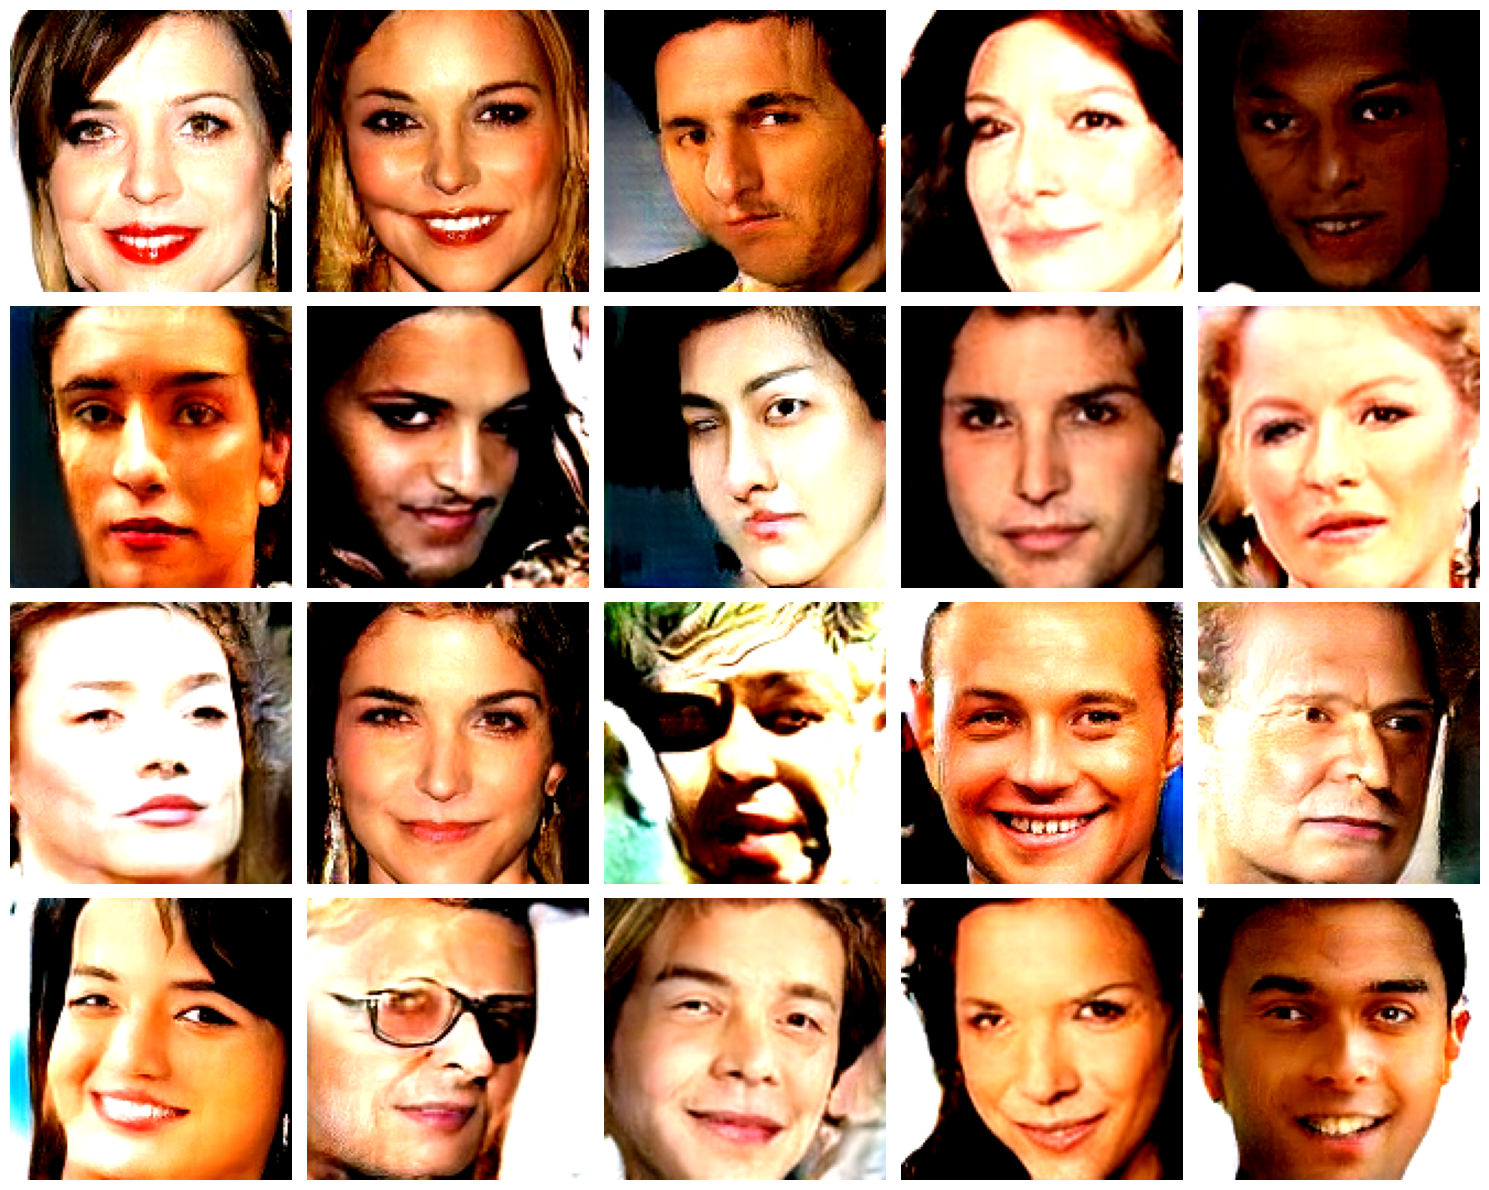

In [75]:
rows,cols = 4,5
plt.figure(figsize=(15, 12))  
for i in range(1, rows * cols + 1):
    plt.subplot(rows, cols, i)
    plt.imshow(imgs[i - 1])
    plt.axis('off')  # Turn off axis numbers and labels
plt.tight_layout()
plt.show()

### Extra Analysis

Now, let's try to generate a realistic face similar to a target outside of the scope of the CelebA dataset. First, let us import the image and display it. 

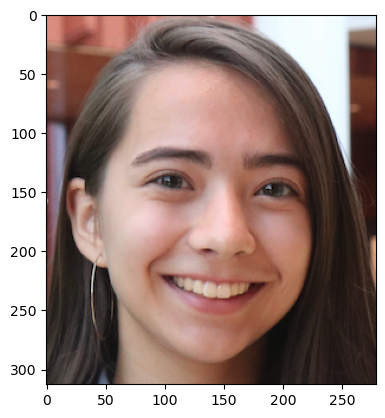

In [60]:
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import numpy as np
# load in the original image
img = cv2.imread(r"img1.png")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Next step is to take the image and process it to make it appropriate for running through our GAN. We will use a random image as our initial image.

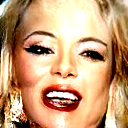

In [61]:
tf.random.set_seed(79)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])


In [69]:
#resized_img = cv2.resize(img, (128, 128))
#cv2.imwrite("img1resized.png", resized_img)
#target_image = imageio.imread("img1resized.png")
target_image = transform.resize(img, [128, 128])
display_image(target_image)
#print(target_image)
target_image = tf.convert_to_tensor(target_image, np.float32)
print(target_image)



tf.Tensor(
[[[0.51608557 0.57176644 0.8630265 ]
  [0.50338066 0.56051624 0.8620257 ]
  [0.50361073 0.56060684 0.86124843]
  ...
  [0.9524763  0.914969   0.8680929 ]
  [0.95579046 0.92003435 0.8651765 ]
  [0.95776457 0.92162734 0.86411494]]

 [[0.5005029  0.5587899  0.8584329 ]
  [0.49951825 0.55851024 0.85760015]
  [0.4973332  0.55504787 0.8597007 ]
  ...
  [0.9647261  0.9263257  0.8718618 ]
  [0.96444094 0.9256314  0.87198234]
  [0.9665383  0.92855304 0.87316704]]

 [[0.4990285  0.5564844  0.8575142 ]
  [0.5014314  0.5575282  0.8577168 ]
  [0.50389206 0.5514159  0.8636064 ]
  ...
  [0.9701269  0.92919683 0.88236386]
  [0.97017384 0.926138   0.8862375 ]
  [0.96883154 0.9249495  0.8877591 ]]

 ...

 [[0.11993497 0.13111883 0.14762583]
  [0.16420694 0.17387392 0.19851583]
  [0.19482724 0.20531903 0.2359489 ]
  ...
  [0.13151334 0.14624414 0.20302941]
  [0.11197891 0.12711434 0.18226844]
  [0.11957933 0.1354593  0.18896459]]

 [[0.12540552 0.14055991 0.15812932]
  [0.16970037 0.18286547 0

In the below code block, I ran into an error where I was not able to collect the 128x128 image into an appropriate format. This would require more exploration into progan(), which seems to take a different format from what we have running here. I would like to explore this further to include data outside of the dataset in an appropriate fashion. The tensor taken is of: shape=(1, 512), dtype=float32. On our above image, we have shape=(128, 128, 3), dtype=float32, since it is 128x128 pixels with RGB. 

In [ ]:
#images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)
